In [15]:
import torch.optim as optim
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt

## Preparing dataset

In [2]:
# Useful Constants
# Output classes to learn how to classify
LABELS = [    
    "JUMPING",
    "JUMPING_JACKS",
    "BOXING",
    "WAVING_2HANDS",
    "WAVING_1HAND",
    "CLAPPING_HANDS"

] 
DATASET_PATH = "data/HAR_pose_activities/database/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 32 # 32 timesteps per series
n_categories = len(LABELS)

In [3]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    blocks = int(len(X_) / n_steps)
    
    X_ = np.array(np.split(X_,blocks))

    return X_ 

# Load the networks outputs
def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)
X_test = load_X(X_test_path)

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

y_train = np.squeeze(y_train)
y_test = np.squeeze(y_test)

# Parameters

In [4]:
BATCH_SIZE = 128
HIDDEN_DIM = 128
NUM_LAYERS = 3

NUM_JOINTS = 18*2
NUM_CLASSES = 6
SEQ_LEN = 32

LOG_INTERVAL = 10
NUM_EPOCHS = 600

## Dataset Loader

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [6]:
class PoseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = torch.from_numpy(data)        
        self.labels = torch.LongTensor(labels)
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index, :, :]
        y = self.labels[index].long()

        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [7]:
train_dataset = PoseDataset(X_train, y_train, transform=None)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

valid_dataset = PoseDataset(X_test, y_test, transform=None)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)    

## Model

In [8]:
class Net(nn.Module):
    def __init__(self, input_dim, seq_len, hidden_dim, num_classes, layer_num):
        super(Net,self).__init__()
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        self.bn = nn.BatchNorm1d(seq_len)
        
    def forward(self,inputs):
        x = self.bn(inputs)
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [9]:
model = Net(NUM_JOINTS, SEQ_LEN, HIDDEN_DIM, NUM_CLASSES, NUM_LAYERS).to(device)
model

Net(
  (lstm): LSTM(36, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=6, bias=True)
  (bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

## Training 

In [11]:
losses = {}
losses['train'] = []
losses['valid'] = []
accuracies = {}
accuracies['train'] = []
accuracies['valid'] = []

train_batches = len(train_loader) 
valid_batches = len(valid_loader)

In [12]:
# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_acc = 100. * correct/total
    train_loss /= train_batches
    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(valid_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)            
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_acc = 100. * correct / total
    val_loss /= valid_batches
    
    if epoch % LOG_INTERVAL == 0:
        print('Epoch: %d | Loss: %.3f | Acc: %.3f%% | Valid Loss: %.3f | Valid Acc: %.3f%%' %
              (epoch, train_loss, train_acc, val_loss, val_acc))
    
    losses['train'].append(train_loss)
    accuracies['train'].append(train_acc)   
    losses['valid'].append(val_loss)
    accuracies['valid'].append(val_acc)    
    

In [13]:
for epoch in range(1, NUM_EPOCHS + 1):
    train(epoch)
    scheduler.step()

Epoch: 10 | Loss: 1.741 | Acc: 22.343% | Valid Loss: 1.731 | Valid Acc: 22.831%
Epoch: 20 | Loss: 1.738 | Acc: 22.343% | Valid Loss: 1.728 | Valid Acc: 22.831%
Epoch: 30 | Loss: 1.736 | Acc: 22.343% | Valid Loss: 1.726 | Valid Acc: 22.831%
Epoch: 40 | Loss: 1.731 | Acc: 23.562% | Valid Loss: 1.722 | Valid Acc: 24.152%
Epoch: 50 | Loss: 1.719 | Acc: 31.412% | Valid Loss: 1.710 | Valid Acc: 32.134%
Epoch: 60 | Loss: 1.512 | Acc: 45.114% | Valid Loss: 1.457 | Valid Acc: 47.905%
Epoch: 70 | Loss: 1.096 | Acc: 52.265% | Valid Loss: 1.068 | Valid Acc: 55.121%
Epoch: 80 | Loss: 0.704 | Acc: 69.344% | Valid Loss: 0.726 | Valid Acc: 71.431%
Epoch: 90 | Loss: 0.553 | Acc: 72.729% | Valid Loss: 0.540 | Valid Acc: 75.969%
Epoch: 100 | Loss: 0.492 | Acc: 77.604% | Valid Loss: 0.495 | Valid Acc: 77.673%
Epoch: 110 | Loss: 0.404 | Acc: 83.916% | Valid Loss: 0.422 | Valid Acc: 82.473%
Epoch: 120 | Loss: 0.340 | Acc: 87.775% | Valid Loss: 0.368 | Valid Acc: 85.585%
Epoch: 130 | Loss: 0.271 | Acc: 91.30

## Results 

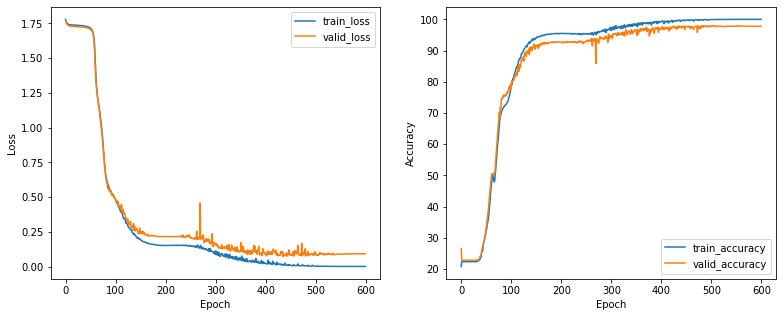

In [14]:
plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(NUM_EPOCHS), losses['train'], label="train_loss")
plt.plot(range(NUM_EPOCHS), losses['valid'], label="valid_loss")
plt.legend()
plt.subplot(1,2,2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(NUM_EPOCHS), accuracies['train'], label="train_accuracy")
plt.plot(range(NUM_EPOCHS), accuracies['valid'], label="valid_accuracy")
plt.legend()
plt.show()

In [9]:
def get_all_preds(model, loader):
    all_preds = torch.tensor([]).to(device)
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        preds = model(inputs)
        all_preds = torch.cat((all_preds, preds), dim=0)
    return all_preds

In [13]:
model.eval()
with torch.no_grad():
    train_preds = get_all_preds(model, valid_loader)

train_preds = train_preds.argmax(1)
train_preds = train_preds.cpu().detach().numpy()

/home/batselem/anaconda3/envs/kaggle/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/aten/src/ATen/native/cudnn/RNN.cpp:968.)
  return forward_call(*input, **kwargs)


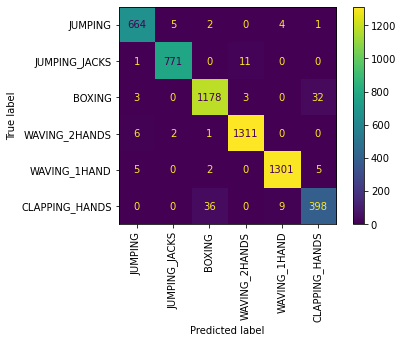

In [16]:
from sklearn import metrics

cm = metrics.confusion_matrix(y_test, train_preds)
cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = LABELS)
cm_display.plot(xticks_rotation='vertical')
plt.show()

## Export model 

In [18]:
sample_input = torch.rand(1, SEQ_LEN, NUM_JOINTS)

# Export to ONNX
torch.onnx.export(model.to('cpu'), sample_input, "action_lstm.onnx") 

/home/batselem/anaconda3/envs/kaggle/lib/python3.9/site-packages/torch/onnx/symbolic_opset9.py:3220: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


In [22]:
# Export to TorchScript
model_scripted = torch.jit.script(model.to('cpu')) 
model_scripted.save('action_lstm.pt') # Save

## Load model 

In [12]:
model = torch.jit.load('action_lstm.pt').to(device)
model.eval()

RecursiveScriptModule(
  original_name=Net
  (lstm): RecursiveScriptModule(original_name=LSTM)
  (fc): RecursiveScriptModule(original_name=Linear)
  (bn): RecursiveScriptModule(original_name=BatchNorm1d)
)